In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

path = 'services/backend/data/shoe_pngs'
files = os.listdir(os.path.join(os.getcwd(),path))
file_paths = [os.path.join(os.getcwd(),path,file) for file in files]
imgs = [Image.open(file_path) for file_path in file_paths]

In [2]:
def crop_whitespace(image):
    img = np.array(image)

    def find_first_non_white_row(image_array,threshold):
        for row in range(image_array.shape[0]):
            if (np.sum(image_array[row] > 253)/(3*image_array.shape[1]) < threshold):
                return row
        return None

    def find_first_non_white_column(image_array,threshold):
        for col in range(image_array.shape[1]):
            if (np.sum(image_array[:,col] > 253)/(3*image_array.shape[0]) < threshold):
                return col
        return None


    top_row = find_first_non_white_row(img,1)
    bottom_row = find_first_non_white_row(np.flipud(img),0.95)

    left_col = find_first_non_white_column(img,0.97)
    right_col = find_first_non_white_column(np.fliplr(img),0.97)
    left,upper,right,lower = left_col,top_row,img.shape[1]-right_col,img.shape[0] - bottom_row
    cropped_img = img[upper:lower,left:right]
    
    return cropped_img

cropped_imgs = [crop_whitespace(img) for img in imgs]


In [12]:
def add_whitespace_with_ar(img_array,target_ar):

    #current_aspect_ratio = img.shape[1]/img.shape[0]
    desired_height = int(img_array.shape[1]*target_ar)
    rows_to_add = desired_height - img_array.shape[0]

    if rows_to_add > 0:
        white_row = np.full((1,img_array.shape[1],3),255,dtype=np.uint8)
        padded_img_array = np.vstack((white_row,) * rows_to_add + (img_array,))
        return padded_img_array
    else:
        return img_array

def resize_image(img_array,new_size=(224,224)):
    img = Image.fromarray(img_array)
    resized_img = img.resize(new_size)
    return resized_img

max_aspect_ratio = max(shape[0]/shape[1] for shape in [cropped_img.shape for cropped_img in cropped_imgs])
padded_images = [add_whitespace_with_ar(cropped_img,1) for cropped_img in cropped_imgs]
final_images = [resize_image(padded_image) for padded_image in padded_images]


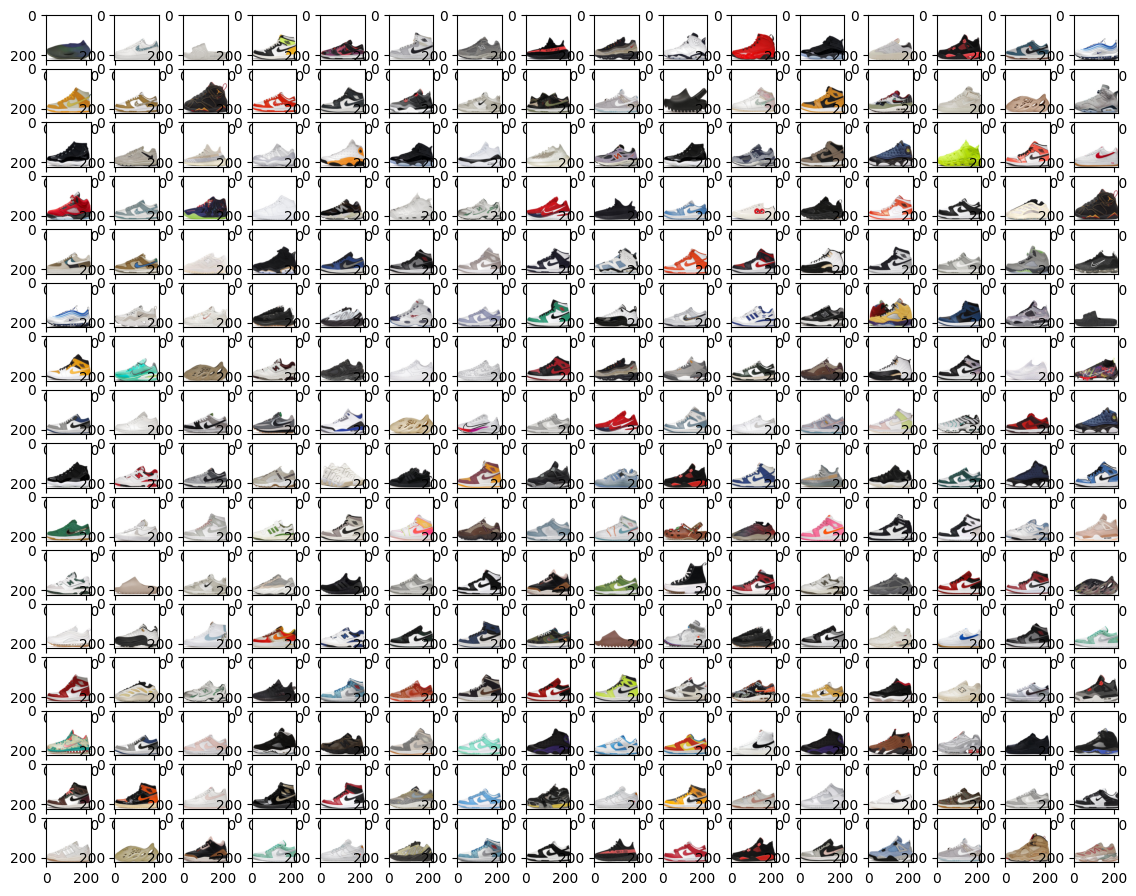

In [13]:
import random
n_rows = 16
n_cols = 16
fig,axs = plt.subplots(n_rows,n_cols,figsize=(14,11))

for i in range(n_rows):
    for j in range(n_cols):
        axs[i,j].imshow(np.array(final_images[random.randrange(len(final_images))]))
        #axs[i,j].set_axis_off()

In [14]:
#GET TOKENS FOR FINETUNING
import pandas as pd

metadata_df = pd.read_csv(os.path.join(os.getcwd(),'data/clean_shoe_metadata.csv'))
tokens_df = pd.read_csv(os.path.join(os.getcwd(),'data/shoe_tokens.csv'))

id                                                    289
title                   Jordan 1 Low Black Grey Pink (GS)
colorway                                  Black/Grey/Pink
releaseDate                                    2022-05-02
retailPrice                                          90.0
brand                                              Jordan
model                                        Jordan 1 Low
lowestAsk                                             114
numberOfAsks                                          143
highestBid                                             89
numberOfBids                                           91
annualHigh                                            218
annualLow                                              45
volatility                                       0.063166
pricePremium                                        0.311
lastSale                                              100
changeValue                                             0
changePercenta

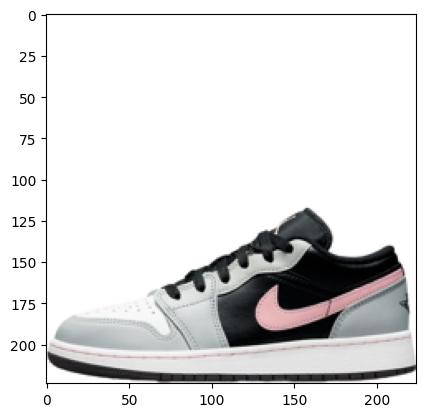

In [15]:
png_path_to_id_mapping = dict(zip(metadata_df['id'],metadata_df['png_path']))

id_to_image_mapping = {}
for id in png_path_to_id_mapping.keys():
    id_to_image_mapping[id] = files.index(png_path_to_id_mapping [id])

test_id = 289
print(metadata_df.loc[metadata_df['id']==test_id].iloc[0])
plt.imshow(np.array(final_images[id_to_image_mapping[test_id]]))

In [29]:
import datetime

prod_ages = (pd.to_datetime(datetime.date(2023,9,13)) - pd.to_datetime(metadata_df['releaseDate'])).dt.days
prod_ages = prod_ages/max(prod_ages)
metadata_df['prod_age'] = prod_ages
metadata_df['prod_age'].fillna(metadata_df['prod_age'].mean(),inplace=True)

metadata_df['prod_sales'] = metadata_df['salesLast72Hours']/max(metadata_df['salesLast72Hours'])
metadata_df['prod_premium'] = (metadata_df['pricePremium'] - min(metadata_df['pricePremium']))/max(metadata_df['pricePremium'] - min(metadata_df['pricePremium']))
metadata_df['prod_high'] = metadata_df['annualHigh']/max(metadata_df['annualHigh'])
metadata_df['prod_low'] = metadata_df['annualLow']/max(metadata_df['annualLow'])

In [30]:
unique_tags = tokens_df['model'].unique()

tag_vectors = {}
for prod_id, group in tokens_df.groupby('prod_id'):
    prod_tag_list = list(group['model'])
    binary_vector = [1 if tag in prod_tag_list else 0 for tag in unique_tags]
    tag_vectors[prod_id] = binary_vector
metadata_df['prod_title_tags'] = metadata_df['id'].map(tag_vectors)

import re
colour_tags = [list(set(x.lower() for x in re.split('/|-| ',cw))) for cw in metadata_df['colorway']]
unique_colour_tags = np.unique([colour for colours in colour_tags for colour in colours])
colour_vectors = [[1 if tag in colour_tag else 0 for tag in unique_colour_tags] for colour_tag in colour_tags]
metadata_df['prod_colour_tags'] = colour_vectors

In [31]:
feature_df = metadata_df[['id','title','colorway','prod_age','prod_sales','prod_premium','prod_high','prod_low','prod_title_tags','prod_colour_tags']]

numerical_columns = ['prod_age','prod_sales','prod_premium','prod_high','prod_low']
tag_columns = ['prod_title_tags','prod_colour_tags']

numerical_vector = feature_df[numerical_columns].to_numpy()
title_tags_vector = feature_df['prod_title_tags']
colour_tags_vector = feature_df['prod_colour_tags']

labels = []
for i in range(len(numerical_vector)):
    labels.append(np.concatenate([numerical_vector[i],title_tags_vector[i],colour_tags_vector[i]]))
labels = np.array(labels)

prod_ids = list(feature_df['id'])
input_images = np.array([np.array(final_images[id_to_image_mapping[prod_id]] )for prod_id in prod_ids])

product_info = feature_df[['id','title','colorway']]
label_names = numerical_columns + list(unique_tags) + list(unique_colour_tags)

print(input_images.shape)
print(labels.shape)

(934, 224, 224, 3)
(934, 694)


In [47]:
label_names = numerical_columns + list(unique_tags) + list(unique_colour_tags)

In [127]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Preprocess your data (assuming you want to use ResNetV2 preprocessing)
images = tf.keras.applications.mobilenet_v2.preprocess_input(input_images)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val, prod_info_train, prod_info_val = train_test_split(images, labels, product_info.to_dict('records'), test_size=0.1, random_state=42)

# Load the pre-trained ResNet50V2 model with weights from ImageNet
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Remove the top layers (including the classifier)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
x = Dense(2048)(x)  # Add your custom layers here
x = LeakyReLU(alpha=0.05,name="embedding")(x)
output = Dense(694, activation='sigmoid')(x)  # Output layer with sigmoid activation for multilabel classification

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# Train the model on your data
batch_size = 32
epochs = 100
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=2 )

# Save the model for future use
#model.save("fine_tuned_resnet50v2.h5")


Epoch 1/100
27/27 - 25s - loss: 0.1127 - accuracy: 0.0714 - val_loss: 0.0592 - val_accuracy: 0.1915 - 25s/epoch - 914ms/step
Epoch 2/100
27/27 - 20s - loss: 0.0460 - accuracy: 0.2226 - val_loss: 0.0403 - val_accuracy: 0.3085 - 20s/epoch - 744ms/step
Epoch 3/100
27/27 - 20s - loss: 0.0350 - accuracy: 0.2310 - val_loss: 0.0365 - val_accuracy: 0.2234 - 20s/epoch - 739ms/step
Epoch 4/100
27/27 - 20s - loss: 0.0302 - accuracy: 0.2417 - val_loss: 0.0343 - val_accuracy: 0.2447 - 20s/epoch - 735ms/step
Epoch 5/100
27/27 - 20s - loss: 0.0268 - accuracy: 0.2655 - val_loss: 0.0326 - val_accuracy: 0.2021 - 20s/epoch - 737ms/step
Epoch 6/100
27/27 - 20s - loss: 0.0237 - accuracy: 0.2857 - val_loss: 0.0328 - val_accuracy: 0.2872 - 20s/epoch - 741ms/step
Epoch 7/100
27/27 - 20s - loss: 0.0211 - accuracy: 0.2821 - val_loss: 0.0317 - val_accuracy: 0.1489 - 20s/epoch - 741ms/step
Epoch 8/100
27/27 - 20s - loss: 0.0187 - accuracy: 0.2714 - val_loss: 0.0319 - val_accuracy: 0.2553 - 20s/epoch - 746ms/step


In [142]:
final_model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
final_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on your data
batch_size = 32
epochs = 10
final_model.fit(
    images, labels,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=2 )

Epoch 1/10
30/30 - 27s - loss: 0.0193 - accuracy: 0.2719 - val_loss: 0.0244 - val_accuracy: 0.2660 - 27s/epoch - 899ms/step
Epoch 2/10
30/30 - 22s - loss: 0.0150 - accuracy: 0.2848 - val_loss: 0.0194 - val_accuracy: 0.2234 - 22s/epoch - 738ms/step
Epoch 3/10
30/30 - 22s - loss: 0.0129 - accuracy: 0.2752 - val_loss: 0.0152 - val_accuracy: 0.2872 - 22s/epoch - 731ms/step
Epoch 4/10
30/30 - 24s - loss: 0.0112 - accuracy: 0.2570 - val_loss: 0.0123 - val_accuracy: 0.2128 - 24s/epoch - 793ms/step
Epoch 5/10
30/30 - 23s - loss: 0.0098 - accuracy: 0.2762 - val_loss: 0.0103 - val_accuracy: 0.2340 - 23s/epoch - 771ms/step
Epoch 6/10
30/30 - 25s - loss: 0.0089 - accuracy: 0.2687 - val_loss: 0.0086 - val_accuracy: 0.2234 - 25s/epoch - 818ms/step
Epoch 7/10
30/30 - 22s - loss: 0.0079 - accuracy: 0.2495 - val_loss: 0.0073 - val_accuracy: 0.1915 - 22s/epoch - 724ms/step
Epoch 8/10
30/30 - 23s - loss: 0.0070 - accuracy: 0.2377 - val_loss: 0.0068 - val_accuracy: 0.2340 - 23s/epoch - 777ms/step
Epoch 9/

In [149]:
feature_extractor = Model(inputs=final_model.input, outputs=final_model.get_layer("embedding").output)
img_features = feature_extractor(images)

In [150]:
img_features[0]

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([ 1.6133708e-01,  4.4200784e-01,  2.1657856e+00, ...,
        1.5981352e+00, -1.5774058e-04, -2.0601641e-01], dtype=float32)>

In [177]:
from sklearn.decomposition import PCA
n_components = 2

pca = PCA(n_components=n_components)
plot_pca = pca.fit_transform(img_features)
images = np.clip(images,0,1)

46


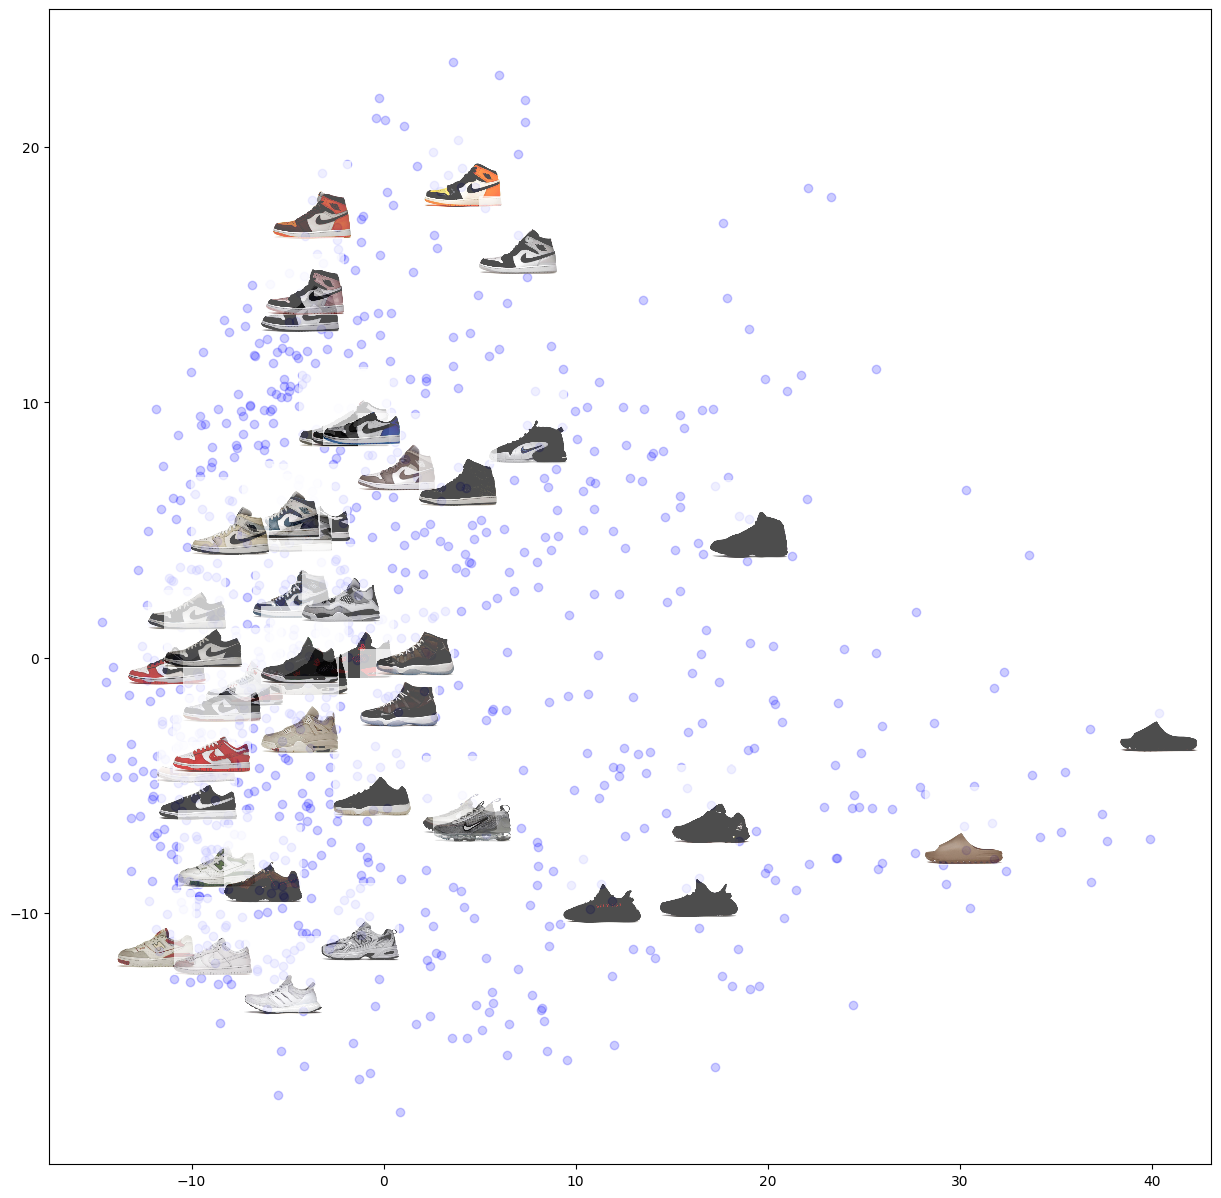

In [181]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(plot_pca[:, 0], plot_pca[:, 1], c='b', marker='o', alpha=0.2, label='Images')

percentage_to_plot = 0.05
num_images_to_plot = int(len(images) * percentage_to_plot)
print(num_images_to_plot)

for i in range(num_images_to_plot):
    x_pca, y_pca = plot_pca[i]
    extent = (x_pca-0.1,x_pca+0.1,y_pca-0.1,y_pca+0.1)
    imagebox = OffsetImage(images[i],zoom=0.25,alpha=0.7)
    ab = AnnotationBbox(imagebox,(x_pca,y_pca), frameon=False)
    ax.add_artist(ab)
plt.show()

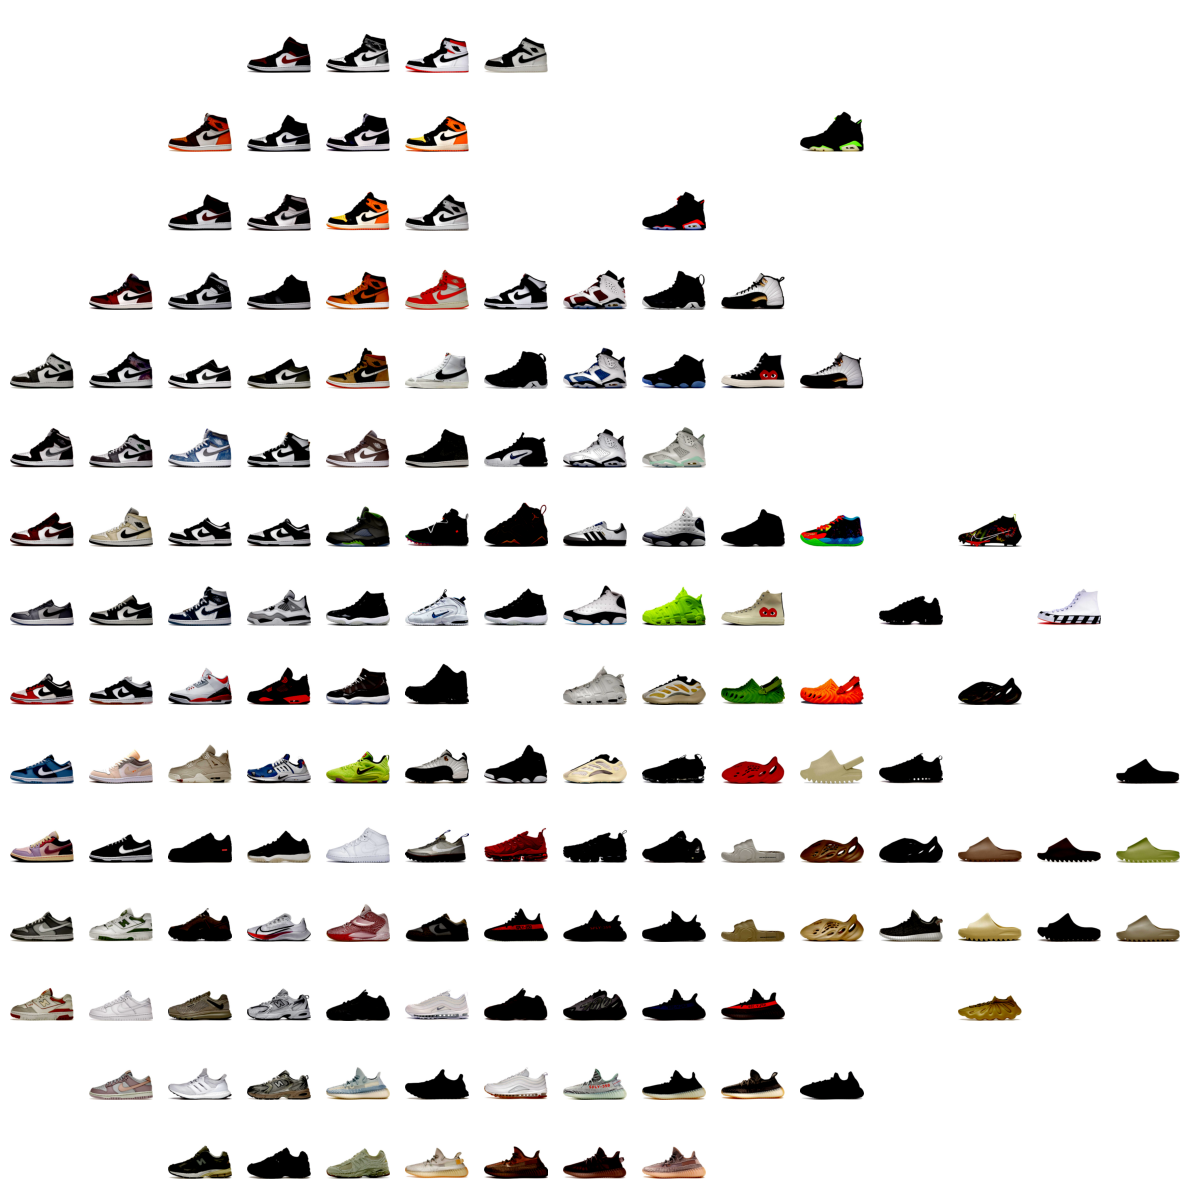

In [191]:
rows, cols = 15,15

# Calculate the x and y ranges for each sector
x_min, x_max = plot_pca[:, 0].min(), plot_pca[:, 0].max()
y_min, y_max = plot_pca[:, 1].min(), plot_pca[:, 1].max()

x_range = np.linspace(x_min, x_max, cols + 1)
y_range = np.linspace(y_min, y_max, rows + 1)
# Create subplots for each grid sector
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))

for i in range(rows):
    for j in range(cols):
        # Define the current sector's boundaries
        x_start, x_end = x_range[j], x_range[j + 1]
        y_start, y_end = y_range[rows - i - 1], y_range[rows - i]
        
        # Find the indices of points that fall within this sector
        indices = np.where((plot_pca[:, 0] >= x_start) & (plot_pca[:, 0] <= x_end) &
                            (plot_pca[:, 1] >= y_start) & (plot_pca[:, 1] <= y_end))[0]
        
        # If there are any points in this sector
        if len(indices) > 0:
            # Display an image if one exists in this sector
            image = images[indices[0]]  # You can adjust this to select a specific image
            axs[i, j].imshow(image, cmap='gray')  # Assuming grayscale images
        axs[i, j].axis('off')  # Turn off axis labels

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [231]:
img_features.shape

TensorShape([934, 2048])

(934, 224, 224, 3)
(934, 128)


In [267]:
import string
from sklearn.decomposition import PCA

n_components = 256

embed_pca = PCA(n_components=n_components)
embedding_pca = embed_pca.fit_transform(img_features)
images = np.clip(images,0,1)

print(images.shape)
print(embedding_pca.shape)

def get_random_string(length):
    # choose from all lowercase letter
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

model_name = "MobileNetV2_2048_PCA"+ str(n_components) + "-" + get_random_string(4)
model_description = "Pretrained MobileNetV2 on imagenet weights retrained using an intermediate dense 2048 layer with numerical features with colourway (Onyx, Black, White, Red, etc.) tags and title tags (Jordan, 11, Nike, Air, Force, 1, etc.) included with a PCA dimension reduction down to 128"
prod_ids = list(product_info['id'])
final_embedding = embedding_pca
print(final_embedding.shape)

(934, 224, 224, 3)
(934, 256)
(934, 256)


In [268]:
from datetime import datetime

# Create a folder 'data' if it doesn't exist
data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

# Create a DataFrame for shoe_models.csv
models_data = pd.DataFrame(columns=['model_name', 'model_description', 'date_created'])

# Check if the model_name already exists in shoe_models.csv
models_file = os.path.join(data_folder, 'shoe_models.csv')
if os.path.exists(models_file):
    models_data = pd.read_csv(models_file)

if model_name not in models_data['model_name'].values:
    # Model doesn't exist, add it
    new_model_data = pd.DataFrame({
        'model_name': [model_name],
        'model_description': [model_description],
        'date_created': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')]
    })
    models_data = pd.concat([models_data, new_model_data], ignore_index=True)

# Save shoe_models.csv
models_data.to_csv(models_file, index=False)

# Create a DataFrame for shoe_embeddings.csv
embeddings_file = os.path.join(data_folder, 'shoe_embeddings.csv')
if os.path.exists(embeddings_file):
    embeddings_data = pd.read_csv(embeddings_file)
else:
    embeddings_data = pd.DataFrame(columns=['model_name','prod_id','embedding'])

new_embeddings_data = pd.DataFrame({
    'model_name': [model_name] * len(prod_ids),  # Corrected the list generation
    'prod_id': prod_ids,  # No need for brackets here
    'embedding': final_embedding.tolist()
})

embeddings_data = pd.concat([embeddings_data, new_embeddings_data], ignore_index=True)

embeddings_data.to_csv(embeddings_file, index=False)


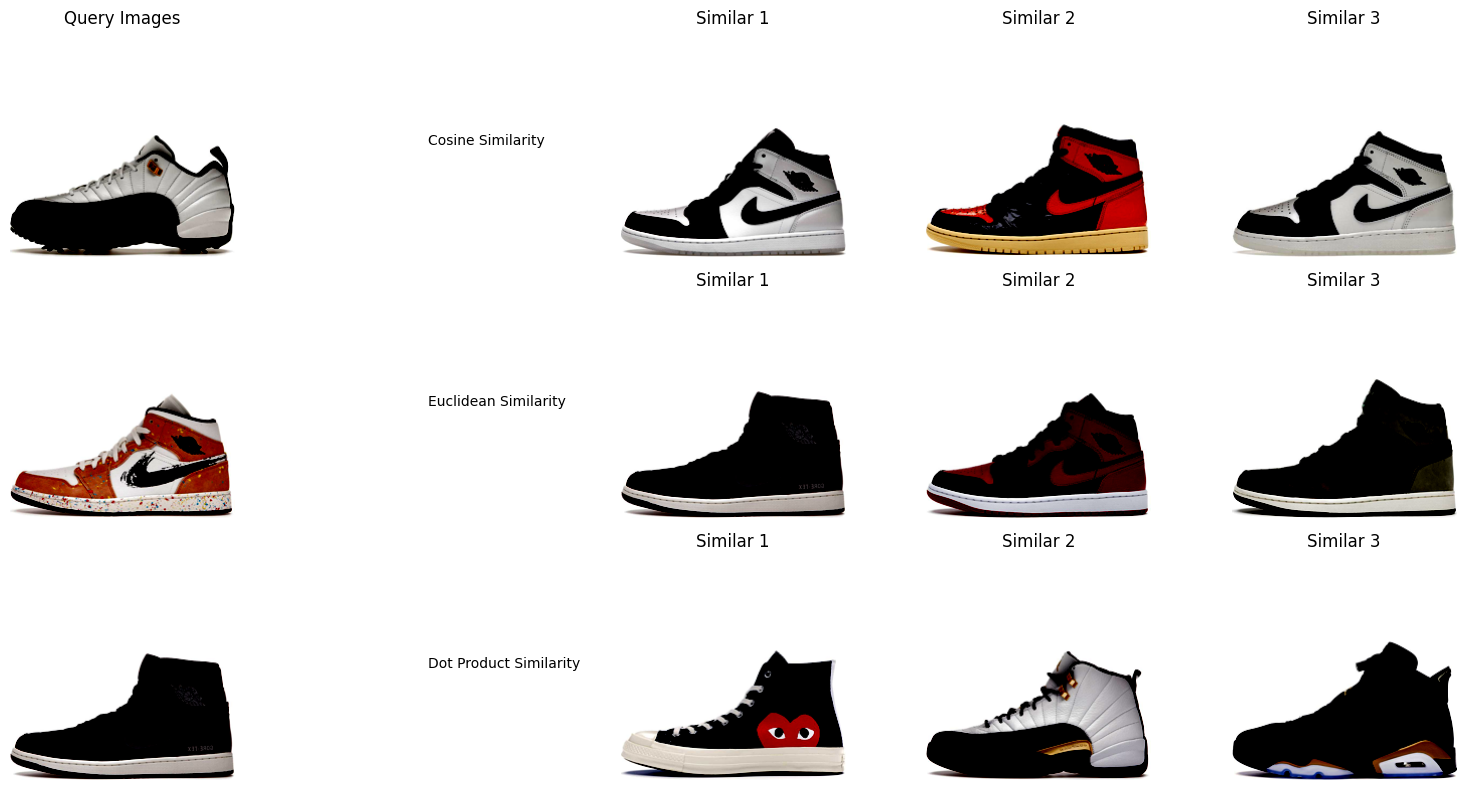

In [233]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Number of similar images to retrieve (top-k)
k = 3
query_image_index = np.random.randint(images.shape[0])
query_images_indices = np.random.randint(images.shape[0],size=k)

query_many = True
if query_many:
    embedding = np.average(embedding_pca[query_images_indices],axis=0)
else:
    embedding = embedding_pca[query_image_index]
# Calculate cosine similarity, Euclidean similarity, and dot product
cosine_sim = cosine_similarity(embedding.reshape(1, -1), embedding_pca)
euclidean_sim = -euclidean_distances(embedding.reshape(1, -1), embedding_pca)
dot_product_sim = np.dot(embedding, embedding_pca.T)

# Sort the images based on similarity scores
cosine_sim_sorted_indices = np.argsort(cosine_sim[0])[::-1]
euclidean_sim_sorted_indices = np.argsort(euclidean_sim[0])[::-1]
dot_product_sim_sorted_indices = np.argsort(dot_product_sim)[::-1]
similar_image_indices = [cosine_sim_sorted_indices,euclidean_sim_sorted_indices,dot_product_sim_sorted_indices]
# Create a subplot grid for plotting
num_plots = k + 2
fig, axes = plt.subplots(3, num_plots, figsize=(15, 8))

# Plot the query image
if query_many:
    axes[0, 0].set_title("Query Images")
    axes[0, 0].imshow(images[query_images_indices[0]])
    axes[1, 0].imshow(images[query_images_indices[1]])
    axes[2, 0].imshow(images[query_images_indices[2]])
else:
    axes[1, 0].set_title("Query Image")
    axes[1, 0].imshow(images[query_image_index])

axes[1, 0].axis('off')
axes[0, 0].axis('off')
axes[2, 0].axis('off')

axes[0, 1].axis('off')
axes[0, 1].text(0.5,0.5,'Cosine Similarity')
axes[1, 1].axis('off')
axes[1, 1].text(0.5,0.5,'Euclidean Similarity')
axes[2, 1].axis('off')
axes[2, 1].text(0.5,0.5,'Dot Product Similarity')
# Plot the top-k most similar images for each similarity metric
for i, (similarity_scores, title) in enumerate(zip([cosine_sim, euclidean_sim, dot_product_sim], ["Cosine Similarity", "Euclidean Similarity", "Dot Product"])):
    for j in range(2, num_plots):
        axes[i, j].imshow(images[similar_image_indices[i][j]])
        axes[i, j].set_title(f"Similar {j-1}")
        axes[i, j].axis('off')

# Adjust spacing for subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
model.predict()

In [50]:
y_val_pred = model.predict(X_val)

6/6 [==============================] - 4s 715ms/step


3/3 [==============================] - 2s 648ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'id': 74, 'title': 'Nike SB Dunk Low Pro Be True', 'colorway': 'White/Multi'}
{'prod_age': 0.100035556, 'prod_sales': 0.037180204, 'prod_premium': 0.23510946, 'prod_high': 0.08029793, 'prod_low': 0.33190277, 'Nike': 0.9998338, 'Dunk': 0.99748003, 'Low': 0.99985063, 'SB': 0.48209783, 'Pro': 0.8317277, 'grey': 0.5403115, 'multi': 0.5249, 'white': 0.9567365}
{'prod_age': 0.10484437163585303, 'prod_sales': 0.020973486347447567, 'prod_premium': 0.22870928829915566, 'prod_high': 0.0855550169655841, 'prod_low': 0.38114754098360654, 'Nike': 1.0, 'Dunk': 1.0, 'Low': 1.0, 'SB': 1.0, 'Pro': 1.0, 'multi': 1.0, 'white': 1.0}


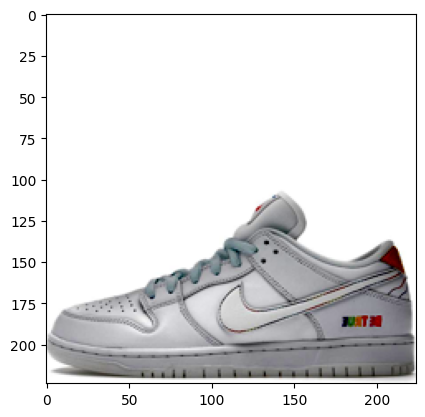

In [144]:
val_prod_id = random.randint(0,len(X_val))

plt.imshow(X_val[val_prod_id])
print(prod_info_val[val_prod_id])
pred_dict = dict(zip(label_names,y_val_pred[val_prod_id]))
print(dict((k,v) for k,v in pred_dict.items() if (v > 0.2 or k in numerical_columns)))
gt_dict = dict(zip(label_names,y_val[val_prod_id]))
print(dict((k,v) for k,v in gt_dict.items() if (v > 0.3 or k in numerical_columns)))

In [145]:
y_val_pred = final_model.predict(images)

30/30 [==============================] - 19s 636ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'prod_age': 0.12813099, 'prod_sales': 0.01346224, 'prod_premium': 0.16684462, 'prod_high': 0.07388077, 'prod_low': 0.28371224, 'Retro': 0.9061527, 'Jordan': 0.99996746, 'High': 0.9791065, 'OG': 0.7859242, 'black': 0.9951639, 'red': 0.97770095, 'varsity': 0.92235017, 'white': 0.9852017}
{'prod_age': 0.1455651766908495, 'prod_sales': 0.006727344677483181, 'prod_premium': 0.2798552472858867, 'prod_high': 0.07149781871061561, 'prod_low': 0.24180327868852458, 'Retro': 1.0, 'Jordan': 1.0, 'High': 1.0, 'OG': 1.0, 'black': 1.0, 'red': 1.0, 'varsity': 1.0, 'white': 1.0}


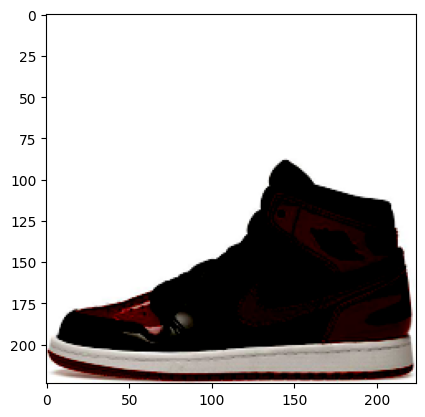

In [148]:
val_prod_id = random.randint(0,len(images))

plt.imshow(images[val_prod_id])
pred_dict = dict(zip(label_names,y_val_pred[val_prod_id]))
print(dict((k,v) for k,v in pred_dict.items() if (v > 0.2 or k in numerical_columns)))
gt_dict = dict(zip(label_names,labels[val_prod_id]))
print(dict((k,v) for k,v in gt_dict.items() if (v > 0.3 or k in numerical_columns)))

{'prod_age': 0.21460332319213668,
 'prod_sales': 0.007518796992481203,
 'prod_premium': 0.24776839565741862,
 'prod_high': 0.07367910809500727,
 'prod_low': 0.36885245901639346,
 'Nike': 1.0,
 'Dunk': 1.0,
 'High': 1.0,
 'blaze': 1.0,
 'orange': 1.0,
 'white': 1.0}